In [1]:
import os
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import statsmodels.api as sm
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
from linearmodels.panel import PanelOLS, compare
from sklearn.linear_model import ElasticNetCV
from sklearn.linear_model import ElasticNet

# Load data
data = pd.read_csv("C:/Users/stunt/OneDrive/Desktop/UCLA Material/Course Material/Machine Learning/Assignments/Wk2/StockRetAcct_DT (1).csv").iloc[:, 1:].dropna()
data

,FirmID,year,lnAnnRet,lnRf,MEwt,lnIssue,lnMom,lnME,lnProf,lnEP,lnInv,lnLever,lnROE,rv,lnBM,ff_ind
0,6,1980,0.363631,0.078944,0.000281,0.031344,0.075355,12.581472,0.201767,0.146411,0.093626,0.696001,0.095294,0.084134,0.633391,3.0
1,6,1981,-0.290409,0.130199,0.000321,0.044213,0.512652,12.907996,0.215661,0.102555,0.087242,0.709843,0.082180,0.056381,0.356723,3.0
2,6,1982,0.186630,0.130703,0.000266,-0.068195,-0.220505,12.557775,0.184087,0.119548,0.111663,0.730972,0.079516,0.062072,0.779405,3.0
3,6,1983,0.489819,0.089830,0.000170,-0.071780,0.046218,12.561954,0.165531,0.115924,-0.033117,0.710885,0.055374,0.076955,0.702113,3.0
4,10,1991,-0.508005,0.061216,0.000033,0.115204,1.341053,11.565831,0.239788,0.023147,0.300051,0.418764,0.146828,0.374368,-2.160942,10.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70749,20308,2013,0.077438,0.001553,0.000222,0.506999,0.356750,15.224147,0.731743,0.059418,0.032970,0.264473,0.545916,0.024212,-2.733524,11.0
70750,20308,2014,0.165333,0.001175,0.000184,-0.046533,0.286393,15.253713,0.731044,0.038293,0.264798,0.392407,0.578908,0.055899,-2.638935,11.0
70753,20314,2012,1.232889,0.002083,0.000210,0.215003,-0.080371,15.008085,-1.264313,-0.089005,0.614060,1.158263,-0.700480,0.251214,-2.664909,2.0
70754,20314,2013,0.804701,0.001553,0.000708,0.260489,1.104453,16.383282,-1.163863,-0.108056,0.445773,2.189972,-1.182673,0.220699,-3.357340,2.0


In [3]:
# Add lnBE and lnBE2
#data["lnMB"] = -data["lnBM"]
data["lnBE"] = data["lnBM"] + data["lnME"]
data["lnBE2"] = (data["lnBM"] + data["lnME"]) ** 2
# Square all other characteristics and interact them with lnBE
col = ["lnIssue", "lnProf", "lnInv", "lnLever", "lnMom", "lnROE", "rv"]
for c in col:
    data[f"{c}2"] = data[c] ** 2
    data[f"{c}inter"] = data[c] * data["lnBE"]

# De-mean by industry-year
for c in col:
    data[[c, f"{c}2", f"{c}inter"]] = data.groupby(['year', 'ff_ind'])[[c,f"{c}2", f"{c}inter"]].transform(lambda x: x - x.mean())
    data[['lnBM', 'lnBE', 'lnBE2']] = data.groupby(['year', 'ff_ind'])[['lnBM','lnBE', 'lnBE2']].transform(lambda x: x - x.mean())
# Data Overview
data.head()

,FirmID,year,lnAnnRet,lnRf,MEwt,lnIssue,lnMom,lnME,lnProf,lnEP,...,lnInv2,lnInvinter,lnLever2,lnLeverinter,lnMom2,lnMominter,lnROE2,lnROEinter,rv2,rvinter
0,6,1980,0.363631,0.078944,0.000281,-0.031518,-0.043815,12.581472,-0.065414,0.146411,...,-0.045275,-0.877767,-0.135418,0.220836,-0.077018,-0.442526,-0.023986,-0.807718,-0.010919,-0.385629
1,6,1981,-0.290409,0.130199,0.000321,-0.016698,0.082219,12.907996,-0.020724,0.102555,...,-0.026850,-0.476887,-0.068848,0.693242,-0.019577,1.503954,-0.019490,-0.677636,-0.012492,-0.657958
2,6,1982,0.186630,0.130703,0.000266,-0.119505,0.063051,12.557775,-0.040975,0.119548,...,-0.017624,0.152454,-0.049602,1.087056,-0.131375,0.704359,-0.022464,-0.704323,-0.010319,-0.506714
3,6,1983,0.489819,0.089830,0.000170,-0.134396,-0.432452,12.561954,0.001125,0.115924,...,-0.012699,-0.701114,-0.070404,0.772906,-0.305134,-5.443163,-0.022040,-0.189306,-0.015790,-0.703336
4,10,1991,-0.508005,0.061216,0.000033,-0.121984,0.846865,11.565831,0.118796,0.023147,...,-0.021621,0.541536,-0.291178,-2.780962,1.383746,7.012217,-0.037233,0.290212,0.057670,0.689237


(0.0, 1.0)

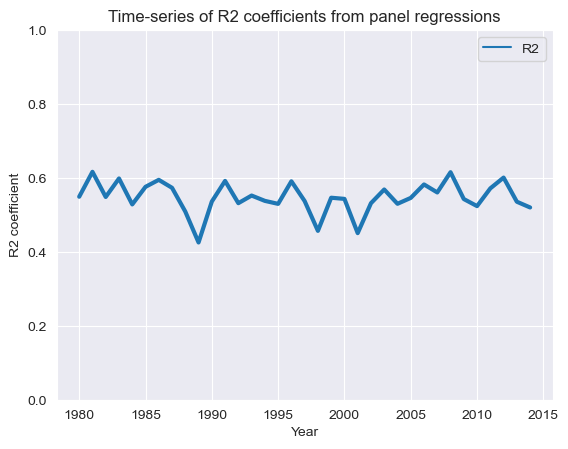

In [5]:
# Initiate iterator and output variables for cross-sectional regression
years = sorted(data['year'].unique())
R2 = np.zeros(len(years))
lnBM_hat_OLS = np.zeros(len(data))
coef_table = pd.DataFrame()
# Each year, regress lnME on all characteristics and industries
for i, t in enumerate(years):
    indx = data['year'] == t
    data_tmp = data.loc[indx].reset_index(drop=True)
    regtmp = smf.ols("lnBM ~ lnBE + lnBE2 + lnIssue + lnIssue2 + lnIssueinter +\
    lnProf + lnProf2 + lnProfinter + lnInv + lnInv2 + lnInvinter+ \
    lnLever + lnLever2 + lnLeverinter + lnMom + lnMom2 +lnMominter +\
    lnROE + lnROE2 + lnROEinter + rv + rv2 + rvinter",data=data_tmp).fit()
    R2[i] = regtmp.rsquared # extracts the R2 coefficient
    tmp = regtmp.params.to_dict()
    tmp['year'] = t
    coef_table = coef_table.append(tmp, ignore_index=True)
    lnBM_hat_OLS[indx] = regtmp.predict(data_tmp) # extraces the fitted values

data["lnBM_hat_OLS"] = lnBM_hat_OLS
# Plot the R2 coefficients across time - these are R2 coefficients WITHIN industries
summary = pd.DataFrame()
summary['year'] = years
summary['R2'] = R2
summary = summary.set_index('year')
sns.set_style('darkgrid')
plt.figure()
ax = sns.lineplot(data=summary, dashes=False, linewidth=3)
ax.set(xlabel='Year',
ylabel='R2 coefficient',
title="Time-series of R2 coefficients from panel regressions")
ax.set_ylim(bottom=0, top=1)



[Text(0.5, 0, 'Year'),
 Text(0, 0.5, 'Coefficient'),
 Text(0.5, 1.0, 'Time-series of coefficients from panel regressions')]

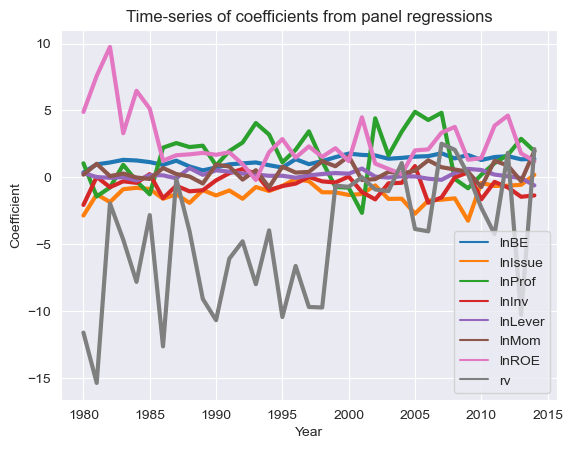

In [6]:
coef_table = coef_table.set_index('year')
sns.set_style('darkgrid')
plt.figure()
ax = sns.lineplot(data=coef_table[['lnBE'] + col], dashes=False, linewidth=3)
ax.set(xlabel='Year',
ylabel='Coefficient',
title="Time-series of coefficients from panel regressions")
#ax.set_ylim(bottom=0, top=1)

## Alpha from mispricing

In [7]:
# Define Fama-MacBeth regression
def ols_coef(x, formula):
    return smf.ols(formula, data=x).fit().params
# Define excess return
data['ExRet'] = np.exp(data.lnAnnRet) - np.exp(data.lnRf)
# Define the mispricing measure z_OLS
data['z_OLS'] = data.lnBM - data.lnBM_hat_OLS
# Run Fama-MacBeth regression
res = (data.groupby('year').apply(ols_coef, 'ExRet ~ z_OLS'))

# Print the result
print('Mean Return: ', str(res['z_OLS'].mean())+'\n',
'Std Dev: ', str(res['z_OLS'].std())+'\n',
'Sharpe Ratio ', str(res['z_OLS'].mean() /
res['z_OLS'].std())+'\n',
't-stat: ', str(len(years)**.5*(res['z_OLS'].mean()) /
res['z_OLS'].std()), sep="\n")

Mean Return: 
0.026386647363474125

Std Dev: 
0.0780109864069528

Sharpe Ratio 
0.33824270886443236

t-stat: 
2.0010708516937177


In [8]:
# Run Fama-MacBeth regression controlling for lnBM, lnProf, lnInv, and lnMom
res = (data.groupby('year').apply(
ols_coef, 'ExRet ~ z_OLS + lnBM_hat_OLS + lnProf + lnInv + lnMom'))
# Print the result
print('Mean Return: ', str(res['z_OLS'].mean())+'\n',
'Std Dev: ', str(res['z_OLS'].std())+'\n',
'Sharpe Ratio ', str(res['z_OLS'].mean() /
res['z_OLS'].std())+'\n',
't-stat: ', str(len(years)**.5*(res['z_OLS'].mean()) /
res['z_OLS'].std()), sep="\n")

Mean Return: 
0.0263866473634743

Std Dev: 
0.07801098640695314

Sharpe Ratio 
0.3382427088644331

t-stat: 
2.001070851693722


In [9]:
# Print the result
print('Mean Return: ', str(res['lnBM_hat_OLS'].mean())+'\n',
'Std Dev: ', str(res['lnBM_hat_OLS'].std())+'\n',
'Sharpe Ratio ', str(res['lnBM_hat_OLS'].mean() /
res['lnBM_hat_OLS'].std())+'\n',
't-stat: ', str(len(years)**.5*(res['lnBM_hat_OLS'].mean()) /
res['lnBM_hat_OLS'].std()), sep="\n")

Mean Return: 
0.024593607952778332

Std Dev: 
0.09802425340392101

Sharpe Ratio 
0.2508930912377097

t-stat: 
1.484303544790782


## Regularization

In [21]:
# Initialize array to store optimal alpha for each year
optimal_alphas = np.zeros(len(years))
data["lnBM_hat_EN"] = np.nan
# Loop over years
for i in range(len(years)):
    year = years[i]
    data_year = data[data["year"] == year]
# ElasticNet with cross-validation
    y_year = data_year["lnBM"]
    X_year = data_year.drop(["lnME", "FirmID", "lnAnnRet", "lnRf", "MEwt","lnEP", "year", "ff_ind", "lnBM_hat_OLS",
    "z_OLS", "ExRet", "lnBM_hat_EN", "lnBM"], axis=1)
    model_year = ElasticNetCV(l1_ratio=0.5, cv=10)
    model_year.fit(X_year, y_year)
    alpha_optim = model_year.alpha_
    optimal_alphas[i] = alpha_optim
    # ElasticNet without cross-validation
    model = ElasticNet(alpha=alpha_optim, l1_ratio=0.5, max_iter=10000)
    model.fit(X_year, y_year)
    data.loc[data.year == year, "lnBM_hat_EN"] = model.predict(X_year)

# Plot the optimal alpha coefficients from cross-validation
summary = pd.DataFrame()
summary['year'] = years
summary['alpha'] = optimal_alphas
summary = summary.set_index('year')
sns.set_style('darkgrid')
plt.figure()
ax = sns.lineplot(data=summary, dashes=False, linewidth=3)
ax.set(xlabel='Year',
ylabel='alpha',
title="Time-series of optimal alpha hyperparameters from cross-validation")
ax.set_ylim(bottom=0, top=0.04)

In [24]:
def ols_r2(x, formula):
    return smf.ols(formula, data=x).fit().rsquared
# Plot the R2 coefficients across time
resr2 = (data.groupby('year').apply(ols_r2, 'lnBM ~ lnBM_hat_EN'))
sns.set_style('darkgrid')
plt.figure()
ax = sns.lineplot(data=resr2, dashes=False, linewidth=3)
ax.set(xlabel='Year',
ylabel='R2 coefficient',
title="Time-series of R2 coefficients from panel regressions")
ax.set_ylim(bottom=0, top=1)